<img src="https://afs-services.com/wp-content/uploads/2025/09/pypricing_banner.png" alt="RV Banner" style="width: 100%; height: auto; display: block;">

# Greek Testing code

The aim of this notebook is to compare the greeks and premium obtained using pypricing and the ones directly from Bloomberg.

The conclusion is that the slight differences could be due to using different discount curves, and different tenors (i.e. Bloomberg uses tenors exact up to hours and minutes, whereas pypricing only up to days).

In [3]:
import sys, os, json
import numpy as np

pypricing_directory = os.path.expanduser("..")
sys.path.insert(1, pypricing_directory)
import afslibrary as afs
import pandas as pd
import db_tools

# db = db_tools.BeautifulDataAFSStyle()
db = db_tools.BeautifulDataAFSStyleXL()
beautiful_data = db_tools.BeautifulDataAFSStyle()
factory = afs.DataFactory(db)
d = afs.DataFactory(beautiful_data)

In [4]:
calendars = d.import_calendar("Act360", "Act365", "Cal30360")
assets = factory.import_underlying("SX5E", "SPX", "RTY", "MT")

We define the option used to compare data. 

In [5]:
K = 4178
maturity = "20231020"
ticker = "SX5E"
calendar = "Act360"
discount_curve = "EURIBOR"
date = "20231010"
vol_df = pd.DataFrame(
    data=[np.array([4178, 0.18, 0])],
    index=pd.DatetimeIndex([date]),
    columns=["Price", "Volatility", "Dividend Rate"],
)
assets["SX5E"].set_data(vol_df)
curve = afs.CRDC(r=0.03768, calendar=calendars[calendar])

We attach screenshots from Bloomberg terminal where we observe the option parametes, its premium and greeks:

![Captura de pantalla 2023-10-10 121829.jpg](<attachment:Captura de pantalla 2023-10-10 121829.jpg>)
![Captura de pantalla 2023-10-10 121748.jpg](<attachment:Captura de pantalla 2023-10-10 121748.jpg>)
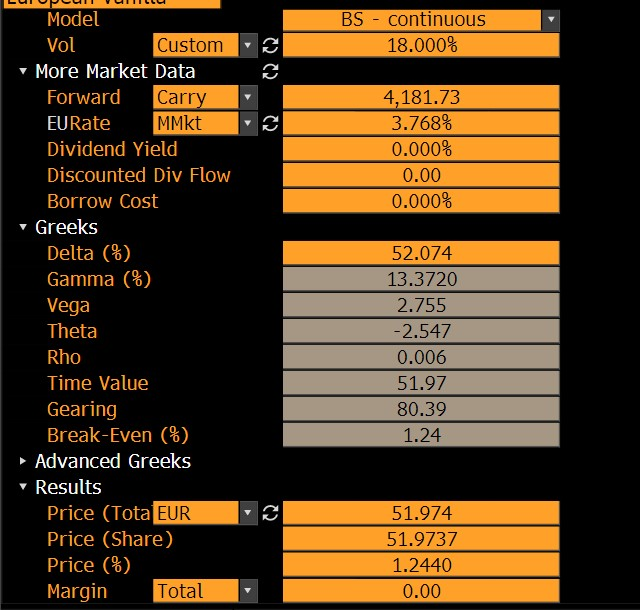
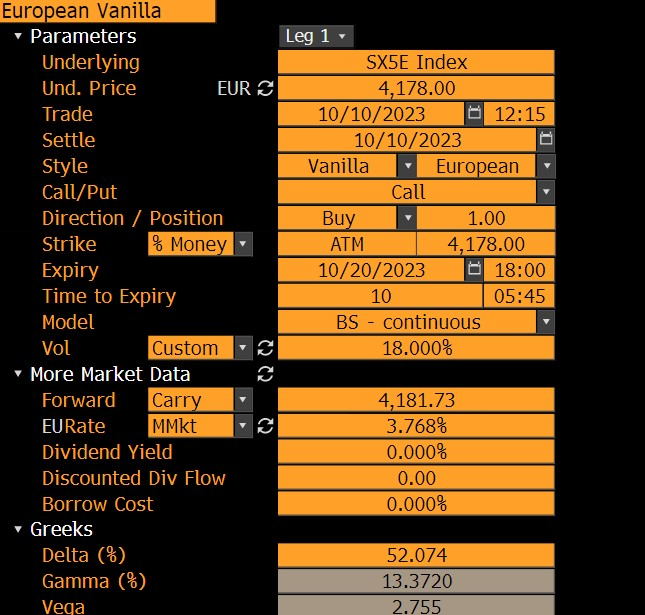

In [6]:
c = afs.Call(assets[ticker], K, maturity, calendars["Act365"], nominal=1)
price = c.get_px(date, curve) * K
delta = c.get_delta(date, curve) * K * 100
gamma = c.get_gamma(date, curve) * K / 2 * 100 * 100
vega = c.get_vega(date, curve) * K / 100
theta = c.get_theta(date, curve) * K / 365
print(f"Price = {price[0]}")
print(f"Delta (%) = {delta[0]}")
print(f"Gamma (x100/2, %) = {gamma[0]}")
print(f"Vega(/100) = {vega[0]}")
print(f"Theta (/365) = {theta[0]}")

Price = 216493.5578243148
Delta (%) = 217154.85588055695
Gamma (x100/2, %) = 66868.4017058111
Vega(/100) = 11512.441871622243
Theta (/365) = -11275.452438331164


We observe the following differences:
* Sometimes there are order of magnitudes (e.g. the range of delta can be 0-1 or 0-100) 
* Bloomberg provides gamma divided by 2
* Bloomberg provides daily delta, ours is annualized (we need to divide by the corresponding count convention)

The **main conclusion** I reach after comparing the results from Bloomberg and from PyPricing is that differences are probably due to a small difference in the discount curve and small differences in the tenor considered (Bloomberg tenor accuracy is minutes, whereas pypricing is days). Additionally, there are also some other differences due to different conventions, these are explained above.